In [1]:
import cdsapi
import os

# Define the filename
filename = 'e08218a823e198c49fd080da0a8e4bd9.nc'

# Check if the file exists
if os.path.exists(filename):
    print(f"✅ The file '{filename}' exists in the current working directory.")
else:
    dataset = "reanalysis-era5-single-levels-monthly-means"
    request = {
        "product_type": ["monthly_averaged_reanalysis"],
        "variable": [
            "sea_surface_temperature",
            "total_column_rain_water"
        ],
        "year": [
            "1979", "1980", "1981",
            "1982", "1983", "1984",
            "1985", "1986", "1987",
            "1988", "1989", "1990",
            "1991", "1992", "1993",
            "1994", "1995", "1996",
            "1997", "1998", "1999",
            "2000", "2001", "2002",
            "2003", "2004", "2005",
            "2006", "2007", "2008",
            "2009", "2010", "2011",
            "2012", "2013", "2014",
            "2015", "2016", "2017",
            "2018", "2019", "2020",
            "2021", "2022", "2023",
            "2024"
        ],
        "month": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12"
        ],
        "time": ["00:00"],
        "data_format": "netcdf",
        "download_format": "unarchived",
        "area": [65, 120, -65, -60]
        #"area": [65, -60, -65, 120] # original area
    
    }
    
    client = cdsapi.Client()
    client.retrieve(dataset, request).download()


✅ The file 'e08218a823e198c49fd080da0a8e4bd9.nc' exists in the current working directory.


In [2]:
import xarray as xr

# Replace 'path/to/your/file.nc' with the actual path to your NetCDF file
# ds = xr.open_dataset('2b6f0454d22c1640314b8379bd5fba20.nc') #original DS
ds = xr.open_dataset('e08218a823e198c49fd080da0a8e4bd9.nc') #test DS with lons flipped.
ds = ds.rename({'valid_time': 'time'})
# Print the Dataset to inspect its contents (variables, dimensions, coordinates, and attributes)
print(ds)

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 552, latitude: 521, longitude: 721)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
  * latitude   (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    expver     (time) <U4 9kB ...
Data variables:
    sst        (time, latitude, longitude) float32 829MB ...
    tcrw       (time, latitude, longitude) float32 829MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-16T02:50 GRIB to CDM+CF via cfgrib-0.9.1...


In [3]:
import numpy as np

def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z


# Example:
# ds is a monthly ERA5 Dataset or DataArray with dimension "time"
# If Dataset, all variables get processed; if DataArray, just that variable
#d s = ds.chunk({"time": -1})  # optional: ensure time is a single chunk for speed
# Optional: keep time in one chunk for speed
ds = ds.chunk({"time": -1})

detr = linear_detrend(ds[["sst", "tcrw"]], time_dim="time")   # or just ds if you want all float vars
anom, z = monthly_anom_and_z(detr, time_dim="time",
                             base_period=("1981-01-01", "2010-12-31"))  # or None for full-period

print(type(z), list(z.data_vars))   # should show a Dataset with ['sst','tcrw']


<class 'xarray.core.dataset.Dataset'> ['sst', 'tcrw']


/opt/anaconda3/lib/python3.13/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


3) Perform an EOF analysis on the SST anomalies and plot a map of the first 5 EOFs, following M04N05.

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from eofs.xarray import Eof

sst_anom = anom['sst'].compute()
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst_anom.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_anom, weights=wgts)

/opt/anaconda3/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/anaconda3/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [5]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
neofs = 5
eofs = solver.eofsAsCorrelation(neofs=neofs)
pcs = solver.pcs(npcs=2, pcscaling=1)

/opt/anaconda3/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


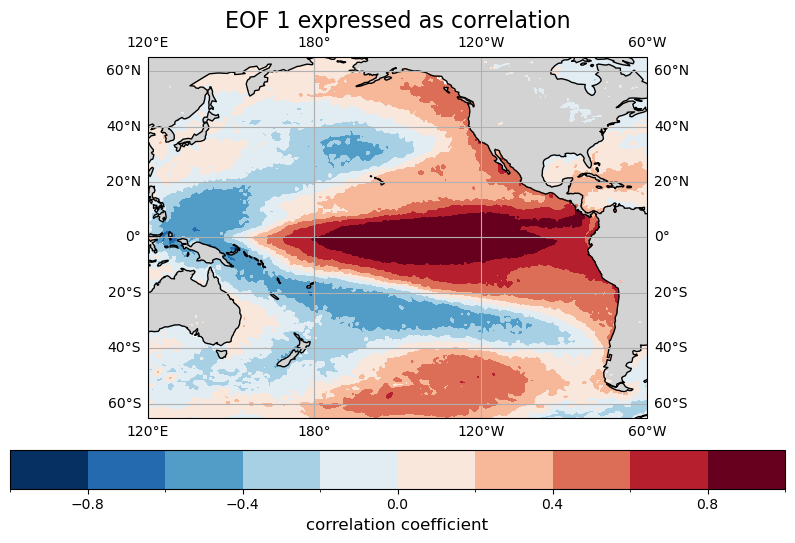

/opt/anaconda3/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


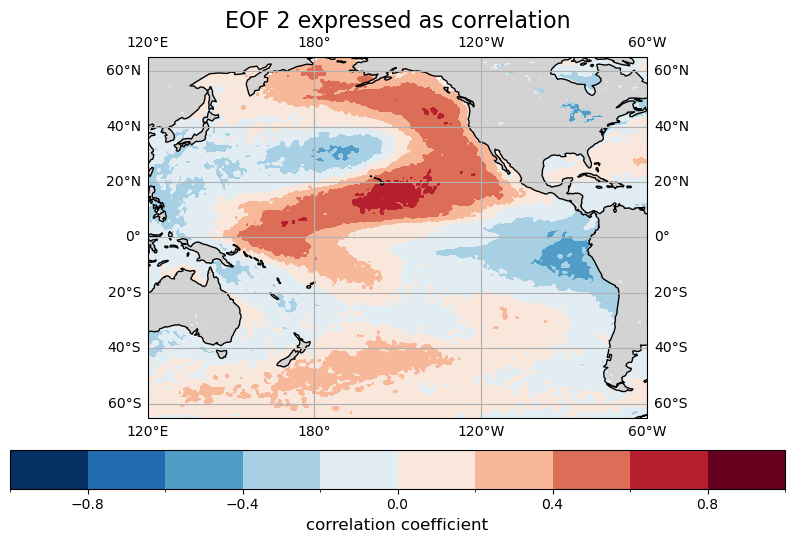

/opt/anaconda3/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


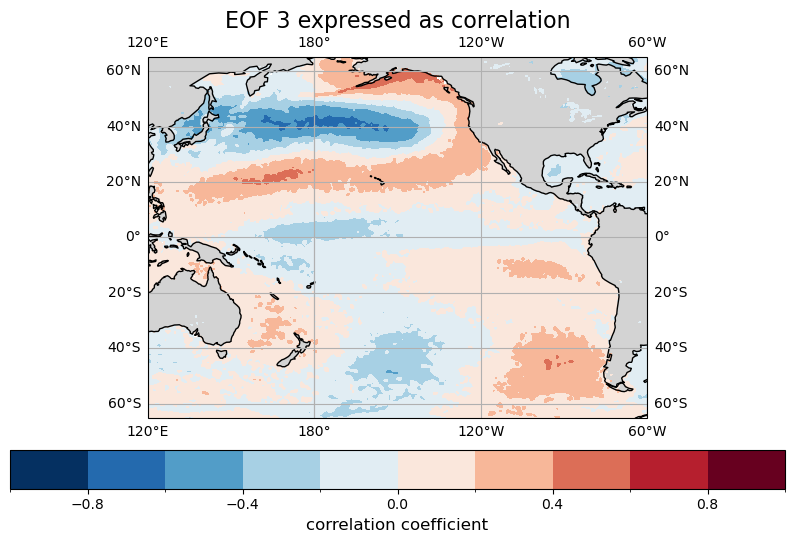

/opt/anaconda3/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


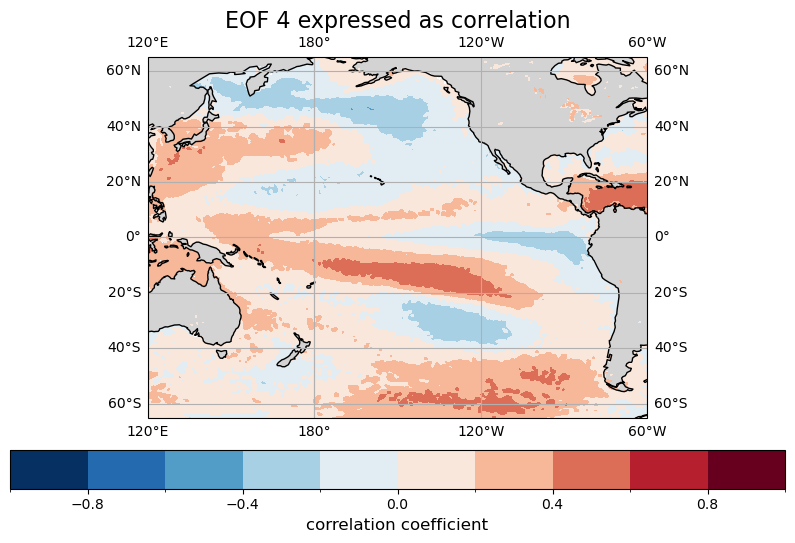

/opt/anaconda3/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


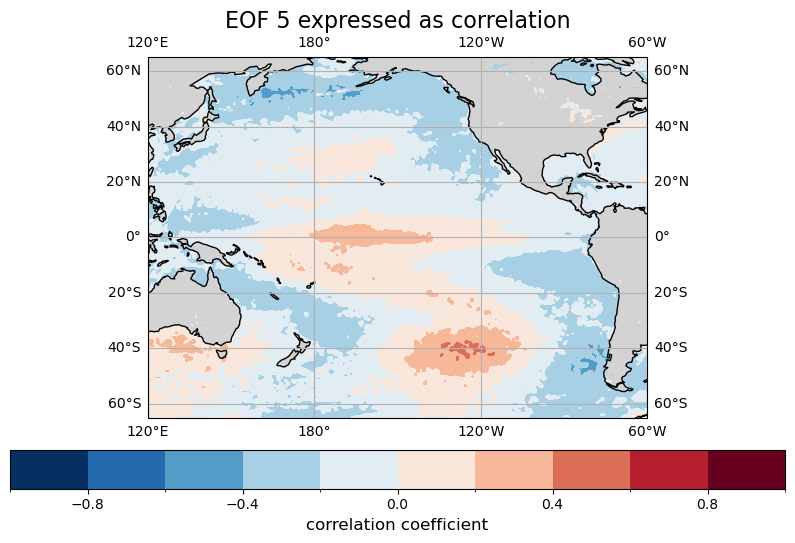

In [7]:
for i in range(neofs): # 'i' is the index (0 for EOF1, 1 for EOF2, etc.)
    
    # 1. Select the current EOF pattern using the index 'i'
    current_eof_map = eofs.isel(mode=i)
        
    # Set up the figure and axes for the current plot
    fig = plt.figure(figsize=(10, 6)) # Create a new figure for each plot
    clevs = np.linspace(-1, 1, 11)
    
    # Central_longitude=190 for a Pacific-centric view
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
    
    # 2. Use the correctly selected DataArray (current_eof_map) for plotting
    fill = current_eof_map.plot.contourf(
        ax=ax, 
        levels=clevs, 
        cmap=plt.cm.RdBu_r,
        add_colorbar=False, 
        transform=ccrs.PlateCarree() # Data is PlateCarree
    )
    
    # Plot configuration
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    
    # Colorbar and Title
    cb = plt.colorbar(fill, orientation='horizontal', pad=0.07)
    cb.set_label('correlation coefficient', fontsize=12)
    
    # The title should reflect the current EOF index
    ax.set_title(f'EOF {i+1} expressed as correlation', fontsize=16) 
    
    plt.show()

    ####### I need to figure out how to get more Eofs

4) Plot the percent of variance explained by the first 10 EOFs.

(6.807842321560759e-14, 27.91974639892578)

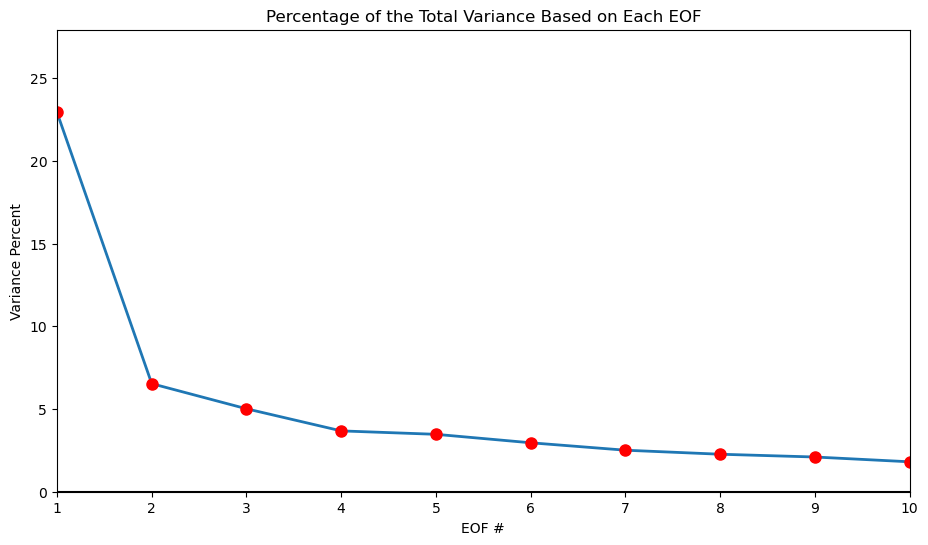

In [8]:
var_frac = solver.varianceFraction()
percent_var = var_frac.values * 100
# Plot the fraction of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, percent_var[0:10], linewidth=2)
plt.plot(eof_num, percent_var[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Percentage of the Total Variance Based on Each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Percent')
plt.xlim(1, 10)
plt.ylim(np.min(percent_var), np.max(percent_var)+5)

5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series (which will be "retrended" and "unstandardized") and the "observed" SST time series.

In [9]:
# Reconstruct the SST anomalies using the first 5 EOFs
reconstruction = solver.reconstructedField(neofs)


sst_correlation = xr.corr(reconstruction, ds['sst'], dim='time')

/opt/anaconda3/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


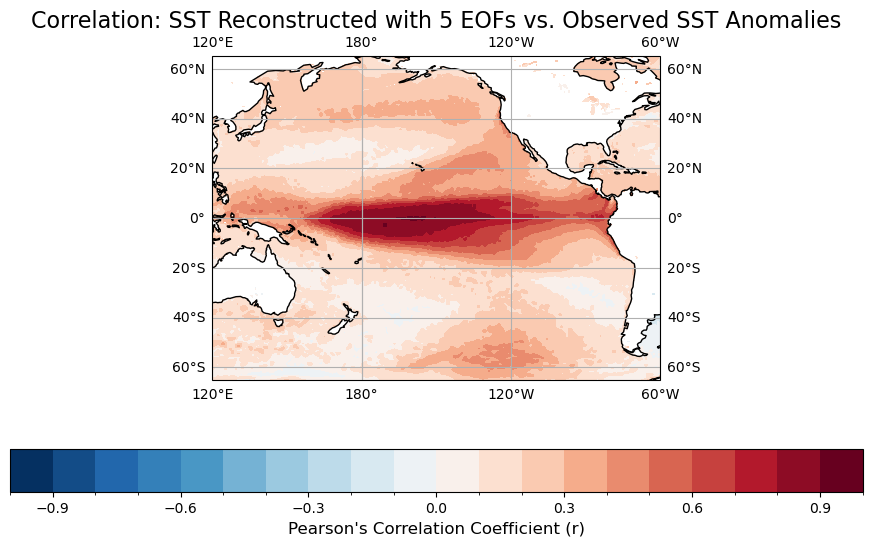

In [20]:
# Set up the map projection
projection = ccrs.PlateCarree(central_longitude=190)
# Set the figure size directly using plt.subplots
fig, ax = plt.subplots(figsize=(11,6), subplot_kw={'projection': projection})
ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())

clevs = np.arange(-1, 1.1, 0.1)

# Plotting the 2D correlation map (no 'time' dimension needed)
fill = sst_correlation.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                                     add_colorbar=False, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')

cb = plt.colorbar(fill, orientation='horizontal')
ax.set_title(f"Correlation: SST Reconstructed with {neofs} EOFs vs. Observed SST Anomalies", fontsize=16)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

cb.set_label('Pearson\'s Correlation Coefficient (r)', fontsize=12)
plt.show()

6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot).  See anything interesting?

In [18]:
pc1 = pcs.isel(mode=0)
# Reconstruct the SST anomalies using the first 5 EOFs
pc1_correlation = xr.corr(anom['tcrw'], pc1, dim='time')

/opt/anaconda3/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


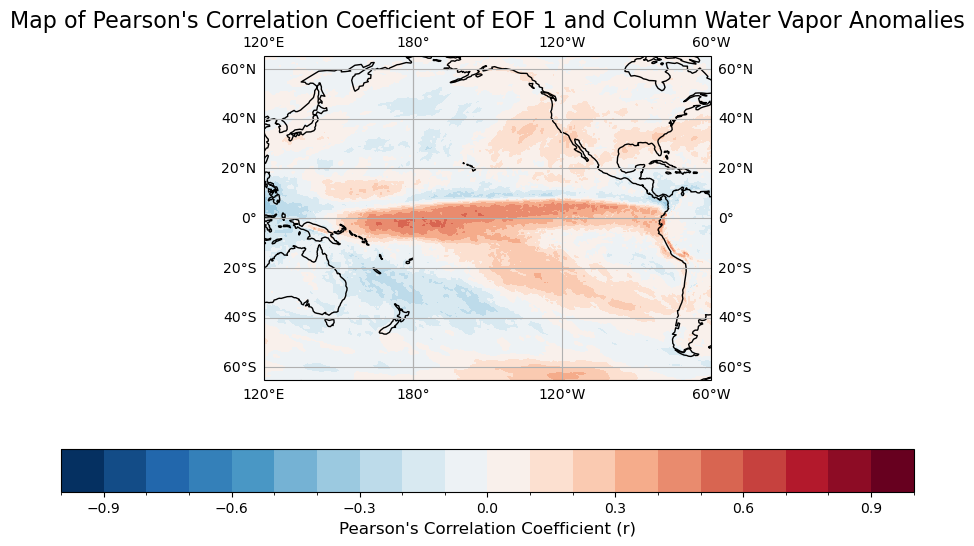

In [21]:
# Set up the map projection
projection = ccrs.PlateCarree(central_longitude=190)
# Set the figure size directly using plt.subplots
fig, ax = plt.subplots(figsize=(11,6), subplot_kw={'projection': projection})
ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())

clevs = np.arange(-1, 1.1, 0.1)

# Plotting tHe 2D correlation map (no 'time' dimension needed)
fill = pc1_correlation.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                                     add_colorbar=False, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')

cb = plt.colorbar(fill, orientation='horizontal')
ax.set_title(f"Map of Pearson's Correlation Coefficient of EOF 1 and Column Water Vapor Anomalies", fontsize=16)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

cb.set_label('Pearson\'s Correlation Coefficient (r)', fontsize=12)
plt.show()